In [9]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
keras  = tf.keras

In [10]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

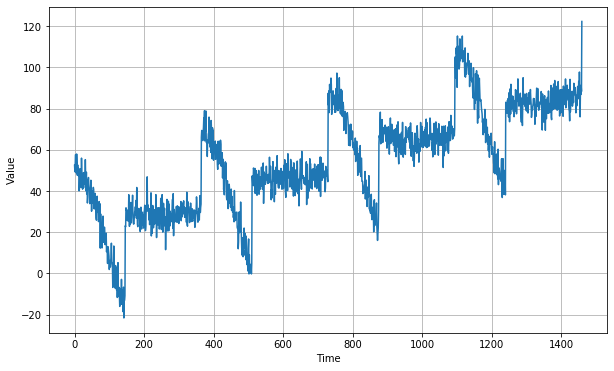

In [11]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

### TIME WINDOW FOR TIME-SERIES (DataPreparation)

In [5]:
# Gives us a bunch of tensors 
data  = tf.data.Dataset.range(10)

# We need to call window method, each window in this dataset is a window itself.
# Call drop_remainder to get the windows exactly 5 elements long and remove the extra elements in the end. 
dataset = data.window(5,shift=1, drop_remainder=True)

# Want batches of data into nested datasets of tensors 
dataset = dataset.flat_map(lambda window : window.batch(5))

# Convert batches into input features and labels
dataset =  dataset.map(lambda window : (window[:-1], window[-1:]))

# Make sure datasets are suffled 
dataset = dataset.shuffle(buffer_size=10)

# Creating batches and parallel loading of  batches for next process (GPU is kept busy)
dataset = dataset.batch(2).prefetch(1)

for input_,label_  in dataset:
    print(input_.numpy(), label_.numpy())
    
    

[[2 3 4 5]
 [1 2 3 4]] [[6]
 [5]]
[[3 4 5 6]
 [4 5 6 7]] [[7]
 [8]]
[[0 1 2 3]
 [5 6 7 8]] [[4]
 [9]]


### wraping this in a function called window dataset

In [12]:
def window_dataset(series, window_size, batch_size = 32, shuffle_buffer=100 ):
    
    # Gives us a bunch of tensors 
    data  = tf.data.Dataset.from_tensor_slices(series)
    
    # We need to call window method, each window in this dataset is a window itself.
    # Call drop_remainder to get the windows exactly 5 elements long and remove the extra elements in the end. 
    dataset = data.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Want batches of data into nested datasets of tensors 
    dataset = dataset.flat_map(lambda window : window.batch(window_size+1))
    # Convert batches into input features and labels
    dataset =  dataset.map(lambda window : (window[:-1], window[-1:]))
    # Make sure datasets are suffled 
    dataset = dataset.shuffle(shuffle_buffer)
    # Creating batches and parallel loading of  batches for next process (GPU is kept busy)
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset


### Forecasting with Machine Learning

In [13]:
#Going to forecast a value given the next given 30days window

# splitting the data

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

### Linear model

In [ ]:
# also we will find an optimal learnig rate by first calling a scheduler and then using the plot to find 
# a value and then using early stoping using the validation set.

In [15]:
# clear cache so we start from zero, not required for production 
keras.backend.clear_session()
tf.random.set_seed(42)

# repeatable
np.random.seed(42)

window_size = 30

# previosuly defined 
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

# model
model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])

# momentum optimizer (SGD)
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)

# selecting the right learning rate (using a learning rate scheduler)
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 30))

# Compile model  (huber loss)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# fit the model for 100 epochs
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 1s 22ms/step - loss: 83.5682 - mae: 83.8147
Epoch 2/100
31/31 [==============================] - 0s 10ms/step - loss: 67.9018 - mae: 68.1316
Epoch 3/100
31/31 [==============================] - 0s 8ms/step - loss: 49.5458 - mae: 50.0156
Epoch 4/100
31/31 [==============================] - 0s 8ms/step - loss: 30.0946 - mae: 30.8092
Epoch 5/100
31/31 [==============================] - 0s 8ms/step - loss: 13.5528 - mae: 14.0578
Epoch 6/100
31/31 [==============================] - 0s 8ms/step - loss: 10.0974 - mae: 10.5778
Epoch 7/100
31/31 [==============================] - 0s 9ms/step - loss: 10.0541 - mae: 10.5240
Epoch 8/100
31/31 [==============================] - 0s 10ms/step - loss: 10.0815 - mae: 10.5010
Epoch 9/100
31/31 [==============================] - 0s 8ms/step - loss: 10.0160 - mae: 10.4813
Epoch 10/100
31/31 [==============================] - 0s 9ms/step - loss: 10.0904 - mae: 10.4644
Epoch 11/100
31/31 [================

31/31 [==============================] - 0s 9ms/step - loss: 50.2995 - mae: 49.5566
Epoch 87/100
31/31 [==============================] - 0s 11ms/step - loss: 81.2305 - mae: 82.0332
Epoch 88/100
31/31 [==============================] - 0s 10ms/step - loss: 41.4664 - mae: 40.6285
Epoch 89/100
31/31 [==============================] - 0s 10ms/step - loss: 44.2793 - mae: 43.6501
Epoch 90/100
31/31 [==============================] - 0s 8ms/step - loss: 37.3087 - mae: 38.3977
Epoch 91/100
31/31 [==============================] - 0s 9ms/step - loss: 120.9155 - mae: 118.0933
Epoch 92/100
31/31 [==============================] - 0s 8ms/step - loss: 58.1310 - mae: 55.4727
Epoch 93/100
31/31 [==============================] - 0s 11ms/step - loss: 46.7360 - mae: 46.7875
Epoch 94/100
31/31 [==============================] - 0s 15ms/step - loss: 119.8567 - mae: 116.6626
Epoch 95/100
31/31 [==============================] - 1s 22ms/step - loss: 37.1472 - mae: 38.3157
Epoch 96/100
31/31 [=============

In [ ]:
### plotting the learnig rate

[1e-07, 0.01, 0, 9]

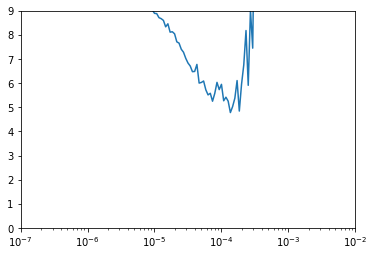

In [45]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-2, 0, 9])

In [ ]:
# optimal learning rate around 1e-5

In [46]:

keras.backend.clear_session()

tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])


optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# early stopping 
early_stopping = keras.callbacks.EarlyStopping(patience=10)

# model fit
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
31/31 [==============================] - 1s 24ms/step - loss: 45.5879 - mae: 46.6270 - val_loss: 24.2773 - val_mae: 24.8110
Epoch 2/500
31/31 [==============================] - 0s 14ms/step - loss: 13.6248 - mae: 14.2586 - val_loss: 9.1670 - val_mae: 9.7700
Epoch 3/500
31/31 [==============================] - 1s 22ms/step - loss: 10.0872 - mae: 10.6537 - val_loss: 9.3679 - val_mae: 9.9795
Epoch 4/500
31/31 [==============================] - 1s 17ms/step - loss: 9.9535 - mae: 10.4066 - val_loss: 9.2565 - val_mae: 9.7444
Epoch 5/500
31/31 [==============================] - 0s 15ms/step - loss: 9.7862 - mae: 10.2415 - val_loss: 8.9242 - val_mae: 9.4089
Epoch 6/500
31/31 [==============================] - 0s 11ms/step - loss: 9.5712 - mae: 10.0605 - val_loss: 8.8885 - val_mae: 9.3480
Epoch 7/500
31/31 [==============================] - 1s 22ms/step - loss: 9.5099 - mae: 9.9797 - val_loss: 8.8343 - val_mae: 9.2354
Epoch 8/500
31/31 [==============================] - 0s 11ms/step

31/31 [==============================] - 0s 14ms/step - loss: 5.8217 - mae: 6.3200 - val_loss: 5.8546 - val_mae: 6.3750
Epoch 63/500
31/31 [==============================] - 0s 16ms/step - loss: 5.8607 - mae: 6.2740 - val_loss: 5.8709 - val_mae: 6.3053
Epoch 64/500
31/31 [==============================] - 0s 12ms/step - loss: 5.8087 - mae: 6.2503 - val_loss: 5.9242 - val_mae: 6.4535
Epoch 65/500
31/31 [==============================] - 0s 13ms/step - loss: 5.8678 - mae: 6.2805 - val_loss: 5.7639 - val_mae: 6.2626
Epoch 66/500
31/31 [==============================] - 0s 13ms/step - loss: 5.7613 - mae: 6.2149 - val_loss: 5.6941 - val_mae: 6.2391
Epoch 67/500
31/31 [==============================] - 0s 14ms/step - loss: 5.6866 - mae: 6.1957 - val_loss: 5.9953 - val_mae: 6.3885
Epoch 68/500
31/31 [==============================] - 0s 12ms/step - loss: 5.6266 - mae: 6.1727 - val_loss: 5.6605 - val_mae: 6.1991
Epoch 69/500
31/31 [==============================] - 0s 12ms/step - loss: 5.6218 

31/31 [==============================] - 1s 18ms/step - loss: 4.7072 - mae: 5.1641 - val_loss: 4.9658 - val_mae: 5.4072
Epoch 124/500
31/31 [==============================] - 0s 15ms/step - loss: 4.6742 - mae: 5.1596 - val_loss: 5.0137 - val_mae: 5.4164
Epoch 125/500
31/31 [==============================] - 1s 17ms/step - loss: 4.6567 - mae: 5.1506 - val_loss: 4.9384 - val_mae: 5.3820
Epoch 126/500
31/31 [==============================] - 0s 14ms/step - loss: 4.8424 - mae: 5.2309 - val_loss: 5.0523 - val_mae: 5.4899
Epoch 127/500
31/31 [==============================] - 0s 14ms/step - loss: 4.6244 - mae: 5.1414 - val_loss: 4.9028 - val_mae: 5.4265
Epoch 128/500
31/31 [==============================] - 0s 13ms/step - loss: 4.6510 - mae: 5.1636 - val_loss: 4.8106 - val_mae: 5.3755
Epoch 129/500
31/31 [==============================] - 0s 15ms/step - loss: 4.6984 - mae: 5.1865 - val_loss: 4.8344 - val_mae: 5.3458
Epoch 130/500
31/31 [==============================] - 0s 14ms/step - loss: 

In [ ]:
## early stoping stops at 150 epochs 

In [48]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [49]:
lin_forecast = model_forecast(model, series[split_time - window_size:-1], window_size)[:, 0]

In [50]:
lin_forecast.shape

(461,)

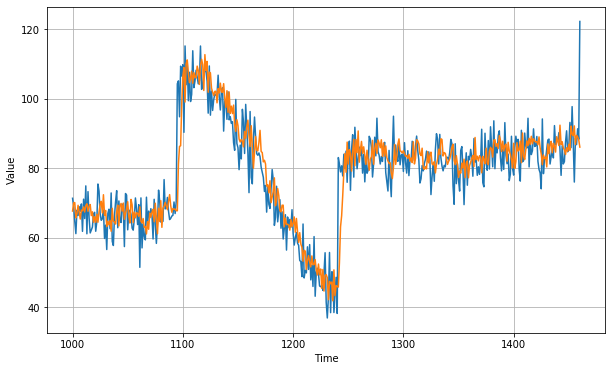

In [51]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, lin_forecast)

In [52]:
keras.metrics.mean_absolute_error(x_valid, lin_forecast).numpy()

5.241611

### Dense model forecasting - Using a 2 hidden layers with 10 neurons each 

In [53]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))

optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 1s 20ms/step - loss: 44.0506 - mae: 44.3568
Epoch 2/100
31/31 [==============================] - 0s 9ms/step - loss: 41.7250 - mae: 42.0294
Epoch 3/100
31/31 [==============================] - 0s 9ms/step - loss: 38.8432 - mae: 39.1394
Epoch 4/100
31/31 [==============================] - 0s 10ms/step - loss: 35.4393 - mae: 35.8273
Epoch 5/100
31/31 [==============================] - 0s 12ms/step - loss: 31.8223 - mae: 32.0867
Epoch 6/100
31/31 [==============================] - 0s 9ms/step - loss: 27.6188 - mae: 27.8666
Epoch 7/100
31/31 [==============================] - 0s 13ms/step - loss: 22.8509 - mae: 23.2083
Epoch 8/100
31/31 [==============================] - 0s 8ms/step - loss: 17.7677 - mae: 18.1641
Epoch 9/100
31/31 [==============================] - 0s 11ms/step - loss: 12.4654 - mae: 12.9776
Epoch 10/100
31/31 [==============================] - 0s 9ms/step - loss: 8.4453 - mae: 8.8292
Epoch 11/100
31/31 [================

31/31 [==============================] - 0s 8ms/step - loss: 33.0416 - mae: 32.9358
Epoch 86/100
31/31 [==============================] - 0s 8ms/step - loss: 42.0489 - mae: 42.2077
Epoch 87/100
31/31 [==============================] - 0s 11ms/step - loss: 41.4549 - mae: 41.6318
Epoch 88/100
31/31 [==============================] - 1s 17ms/step - loss: 40.6332 - mae: 40.9676
Epoch 89/100
31/31 [==============================] - 1s 17ms/step - loss: 39.6604 - mae: 39.8122
Epoch 90/100
31/31 [==============================] - 0s 12ms/step - loss: 40.0155 - mae: 40.0636
Epoch 91/100
31/31 [==============================] - 1s 16ms/step - loss: 38.3846 - mae: 38.4124
Epoch 92/100
31/31 [==============================] - 0s 10ms/step - loss: 33.6851 - mae: 33.8360
Epoch 93/100
31/31 [==============================] - 0s 14ms/step - loss: 17.4156 - mae: 18.0095
Epoch 94/100
31/31 [==============================] - 0s 15ms/step - loss: 18.5351 - mae: 19.0605
Epoch 95/100
31/31 [===============

[1e-07, 0.005, 0, 15]

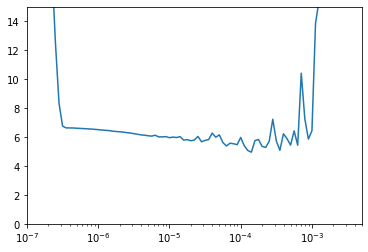

In [56]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 5e-3, 0, 15])

In [55]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

early_stopping = keras.callbacks.EarlyStopping(patience=10)

model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
31/31 [==============================] - 1s 27ms/step - loss: 19.0465 - mae: 19.6409 - val_loss: 12.2194 - val_mae: 12.7230
Epoch 2/500
31/31 [==============================] - 0s 16ms/step - loss: 8.7040 - mae: 9.2288 - val_loss: 7.3431 - val_mae: 7.9687
Epoch 3/500
31/31 [==============================] - 1s 29ms/step - loss: 8.0181 - mae: 8.5222 - val_loss: 7.1244 - val_mae: 7.6451
Epoch 4/500
31/31 [==============================] - 1s 20ms/step - loss: 7.7357 - mae: 8.2168 - val_loss: 6.9185 - val_mae: 7.3756
Epoch 5/500
31/31 [==============================] - 1s 25ms/step - loss: 7.4077 - mae: 7.9372 - val_loss: 6.7155 - val_mae: 7.2508
Epoch 6/500
31/31 [==============================] - 1s 21ms/step - loss: 7.1985 - mae: 7.7237 - val_loss: 6.5109 - val_mae: 6.9986
Epoch 7/500
31/31 [==============================] - 1s 18ms/step - loss: 7.1099 - mae: 7.5587 - val_loss: 6.5539 - val_mae: 6.9665
Epoch 8/500
31/31 [==============================] - 1s 19ms/step - loss

31/31 [==============================] - 0s 12ms/step - loss: 5.3194 - mae: 5.8188 - val_loss: 5.0447 - val_mae: 5.5330
Epoch 63/500
31/31 [==============================] - 0s 10ms/step - loss: 5.2769 - mae: 5.6743 - val_loss: 5.0575 - val_mae: 5.5360
Epoch 64/500
31/31 [==============================] - 0s 11ms/step - loss: 5.1767 - mae: 5.6531 - val_loss: 5.1594 - val_mae: 5.6349
Epoch 65/500
31/31 [==============================] - 0s 11ms/step - loss: 5.1954 - mae: 5.6470 - val_loss: 5.0118 - val_mae: 5.5227
Epoch 66/500
31/31 [==============================] - 0s 13ms/step - loss: 5.1930 - mae: 5.6358 - val_loss: 4.9689 - val_mae: 5.5162
Epoch 67/500
31/31 [==============================] - 0s 12ms/step - loss: 5.1031 - mae: 5.6270 - val_loss: 5.1516 - val_mae: 5.5421
Epoch 68/500
31/31 [==============================] - 0s 13ms/step - loss: 5.0656 - mae: 5.6155 - val_loss: 5.0097 - val_mae: 5.5050
Epoch 69/500
31/31 [==============================] - 0s 13ms/step - loss: 5.0763 

31/31 [==============================] - 0s 10ms/step - loss: 4.7323 - mae: 5.2213 - val_loss: 4.8828 - val_mae: 5.3314
Epoch 124/500
31/31 [==============================] - 0s 9ms/step - loss: 4.7359 - mae: 5.2442 - val_loss: 4.8076 - val_mae: 5.2453
Epoch 125/500
31/31 [==============================] - 0s 10ms/step - loss: 4.6916 - mae: 5.2149 - val_loss: 4.8952 - val_mae: 5.3175
Epoch 126/500
31/31 [==============================] - 0s 10ms/step - loss: 4.8666 - mae: 5.3023 - val_loss: 4.7812 - val_mae: 5.2380
Epoch 127/500
31/31 [==============================] - 0s 9ms/step - loss: 4.7162 - mae: 5.2172 - val_loss: 4.7074 - val_mae: 5.2422
Epoch 128/500
31/31 [==============================] - 0s 9ms/step - loss: 4.7372 - mae: 5.2320 - val_loss: 4.7490 - val_mae: 5.2713
Epoch 129/500
31/31 [==============================] - 0s 10ms/step - loss: 4.7801 - mae: 5.2988 - val_loss: 4.7372 - val_mae: 5.2610
Epoch 130/500
31/31 [==============================] - 0s 10ms/step - loss: 4.8

In [57]:
dense_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size)[:, 0]

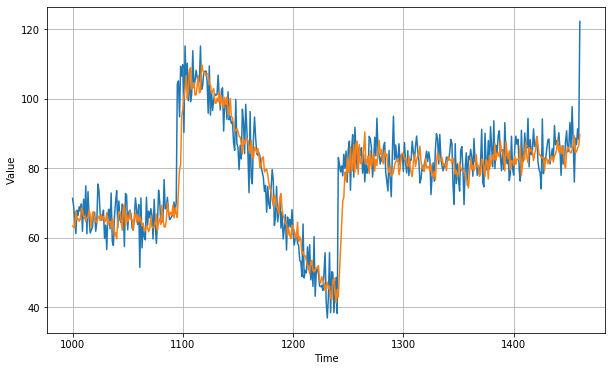

In [58]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, dense_forecast)

In [59]:
keras.metrics.mean_absolute_error(x_valid, dense_forecast).numpy()

5.141464